In [141]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
class value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [143]:
a = value(5.0, label = 'a')
b = value(-4.0,label = 'b')
c = value(8.0,label = 'c')
d = a*b; d.label = 'd'
e =  d+c; e.label = 'e'
f = value(-3.0, label = 'f')
L = e*f
L ; 

In [144]:
#checking if the code unerstands value after assigning the code out = value(self.data+other.data, (self,other), '*')
a = value(2.0)
a-1

value(data=1.0)

In [145]:
L.label = 'L'

In [146]:
#printing the history of operations d._op gives me only the last used operations since all other operations are hidden.
def print_history(v):
    print(f"Value: {v.data}, Op: {v._op}")
    for prev in v._prev:
        print_history(prev)

print_history(d)

Value: -20.0, Op: *
Value: 5.0, Op: 
Value: -4.0, Op: 


In [147]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [148]:
import os
# Set the environment variable for Graphviz
os.environ["PATH"] += os.pathsep + r"C:\Users\uttar\Downloads\windows_10_cmake_Release_Graphviz-12.1.0-win32\graphviz-12.1.0-win32\bin"

In [149]:
import os
import graphviz
import subprocess



# Your code that uses Graphviz
cmd = ['dot', '-Tpng', 'input.dot', '-o', 'output.png']
subprocess.Popen(cmd)


<Popen: returncode: None args: ['dot', '-Tpng', 'input.dot', '-o', 'output.p...>

In [150]:
f.grad = -12.0
e.grad = -3.0
c.grad = -3.0
d.grad = -3.0
a.grad = 12
b.grad = -15

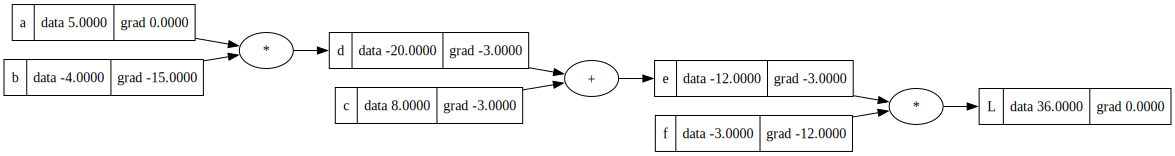

In [151]:
draw_dot(L)

In [152]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

d = a * b
e = d + c
L = e * f

print (L.data)

2.5833600000000065


L=e*f
 
dL/de = ?f

(f(x+h)-f(x))/h

((e+h)*f - e*f)/h
=f

In [153]:
#staging

def lol():

    h = 0.001
    a = value(5.0, label = 'a')
    b = value(-4.0,label = 'b')
    c = value(8.0,label = 'c')
    d = a*b; d.label = 'd'
    e =  d+c; e.label = 'e'
    f = value(-3.0, label = 'f')
    L = e*f; L.label = "L"
    L1 = L.data

    a = value(5.0, label = 'a')
    b = value(-4.0,label = 'b')
    b.data += h
    c = value(8.0,label = 'c')
    d = a*b; d.label = 'd'
    e =  d+c; e.label = 'e'
    f = value(-3.0, label = 'f')
    L = e*f; L.label = "L"
    L2 = L.data

    print ((L2-L1)/h)


lol()

-15.000000000000568


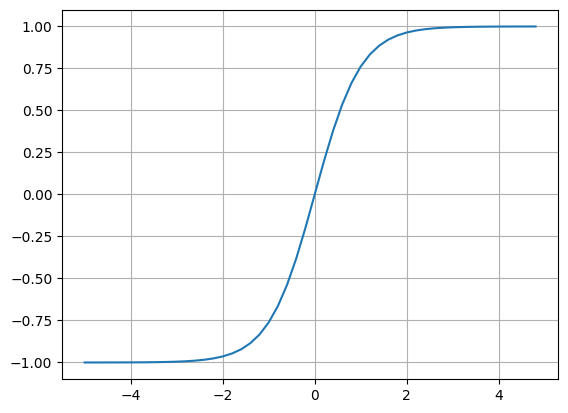

In [154]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Manual approach

In [155]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

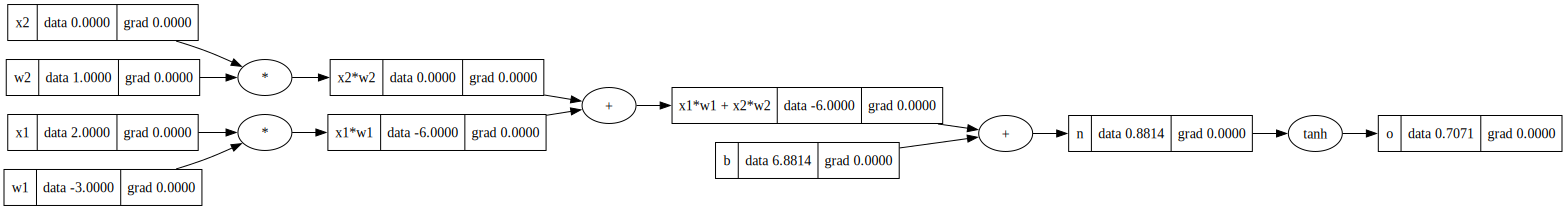

In [156]:
draw_dot(o)

In [157]:
o.grad =1 


In [158]:
#o = tanh(n)
#do/dn = 1-tanh^2(x) = =1-o**2

In [159]:
n.grad = 1-o.data**2 #0.5

In [160]:
# + is a distributor
x1w1x2w2.grad = 0.5
b.grad = 0.5

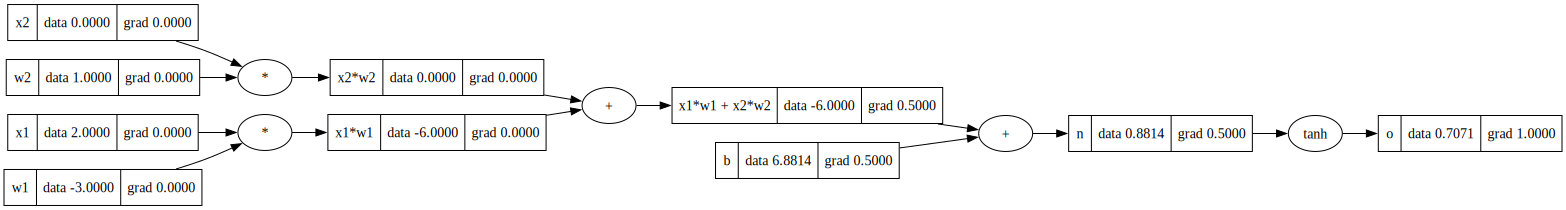

In [161]:
draw_dot(o)

In [162]:
# + is a distributor
x1w1.grad = 0.5
x2w2.grad = 0.5

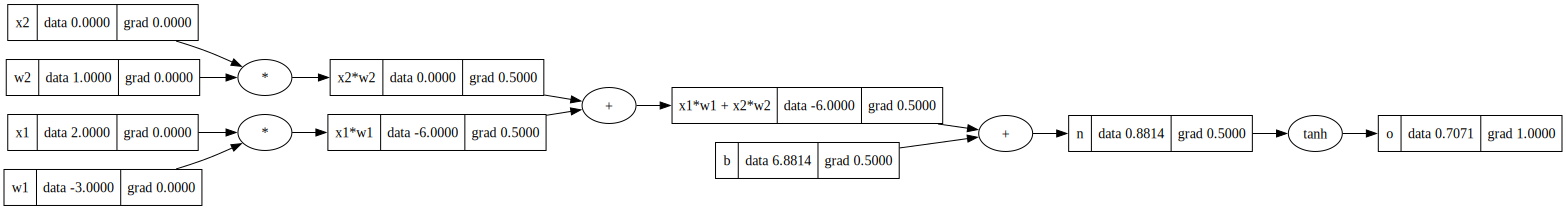

In [163]:
draw_dot(o)

In [164]:
# by chain rule
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

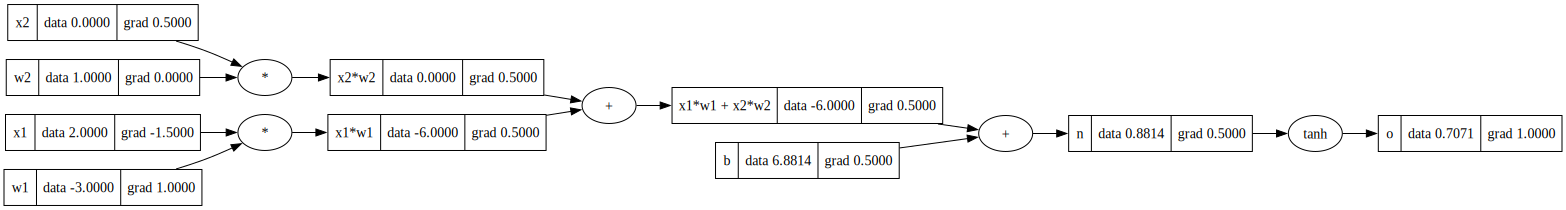

In [165]:
draw_dot(o)

using the defined functions (backward)

In [166]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

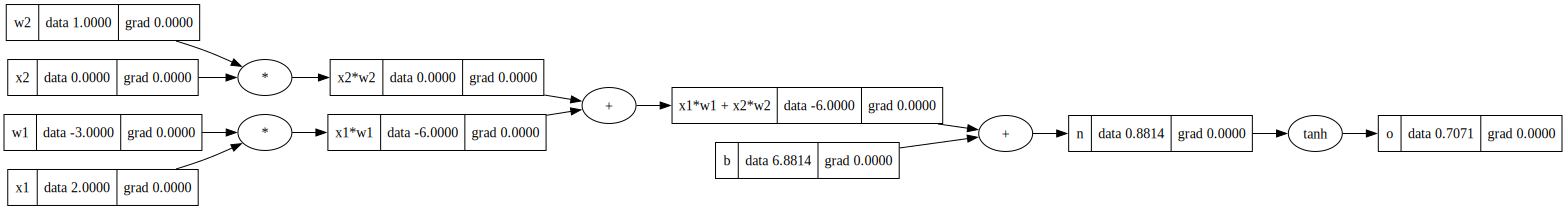

In [167]:
draw_dot(o)

In [168]:
o.grad = 1.0

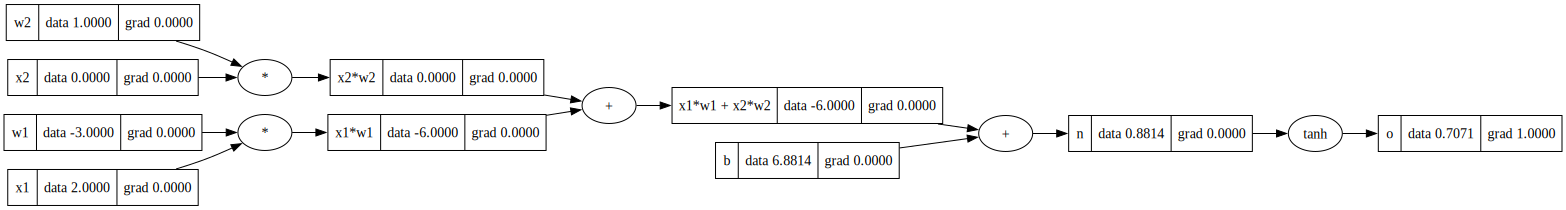

In [169]:
draw_dot(o)

In [170]:
o._backward()

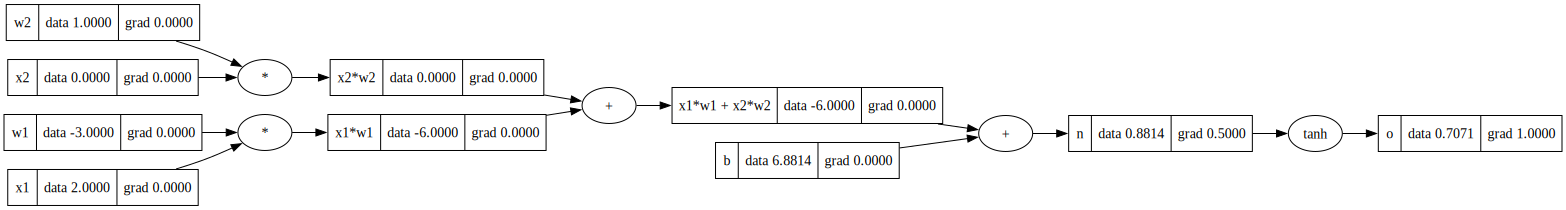

In [171]:
draw_dot(o)

In [172]:
n._backward()

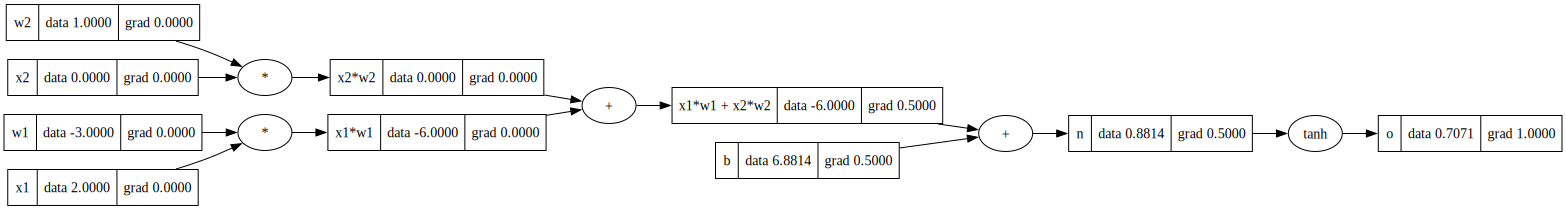

In [173]:
draw_dot(o)

In [174]:
b._backward() # empty because of lambda : none since it's a leaf node

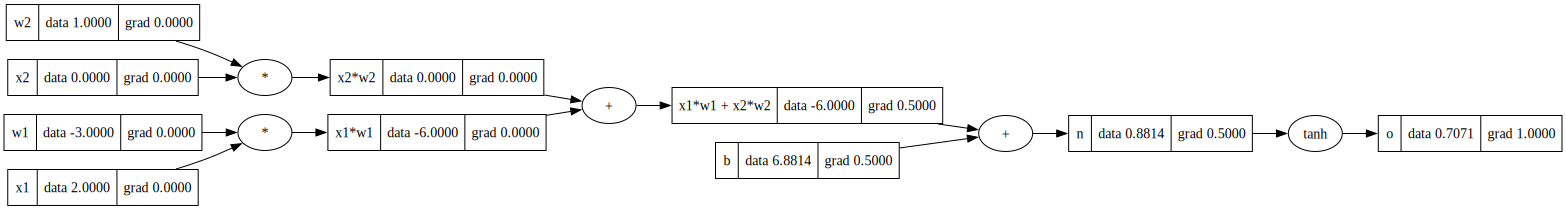

In [175]:
draw_dot(o)

In [176]:
x1w1x2w2._backward()

In [177]:
x2w2._backward()
x1w1._backward()

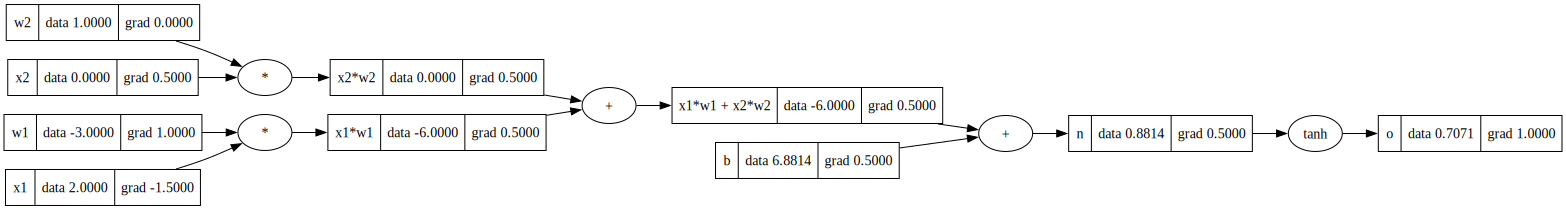

In [178]:

draw_dot(o)

We are calling _backward manually, this needs to be skipped

testing from value class
def backward(self):
                topo = []
                visited = set()
                def build_topo(v):
                        if v not in visited:
                                visited.add(v)
                                for child in v._prev:
                                        build_topo(child)
                                topo.append(v)
                build_topo(self)
                
                self.grad = 1.0
                for node in reversed(topo):
                        node._backward()

In [179]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label = 'o'

In [180]:
o.backward()

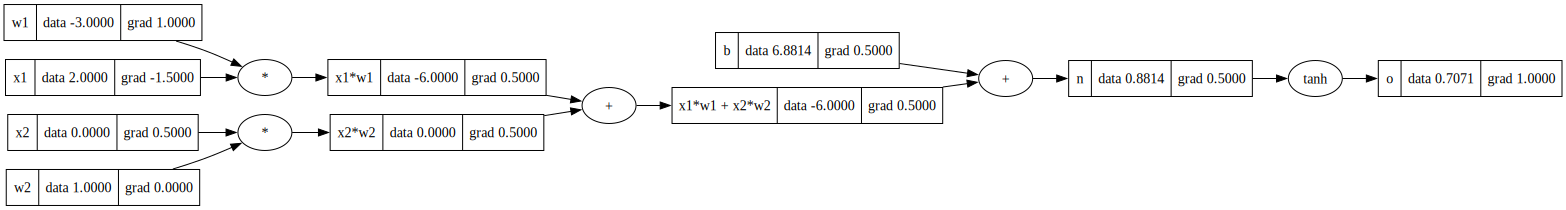

In [181]:
draw_dot(o)

In [182]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

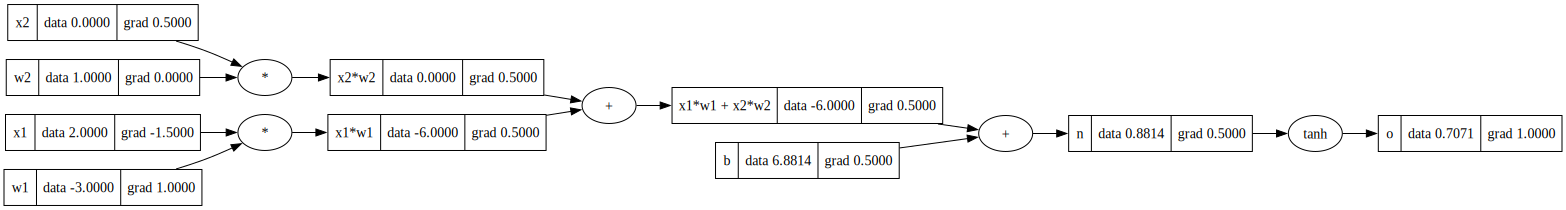

In [183]:
draw_dot(o)

Manual tanh

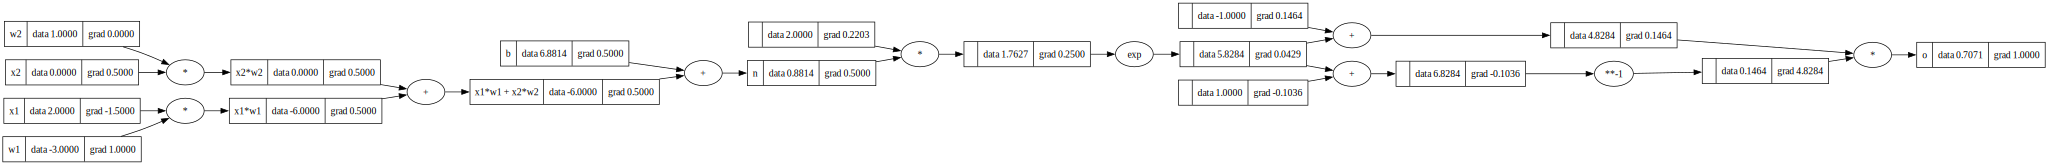

In [185]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); o.label = 'o'
e= (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

Implementing the same Using Pytorch. Phew!

In [186]:
import torch

In [188]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item()) #o.data.item produces same result here
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


building neural net library (multi layer perceptron) in micrograd

In [200]:
import random

In [216]:
class neuron:
    def __init__(self, nin):
        self.w = [value(random.uniform(-1,1)) for _ in range(nin)] #WEIGHT
        self.b = value(random.uniform(-1,1)) #BIAS

    def __call__(self,x):
        #w=x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
  
    def __init__(self, nin, nouts):    #nouts defines sizes of layers in MLP
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    

In [217]:
x = [3.0,4.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

value(data=0.6007776323910973)

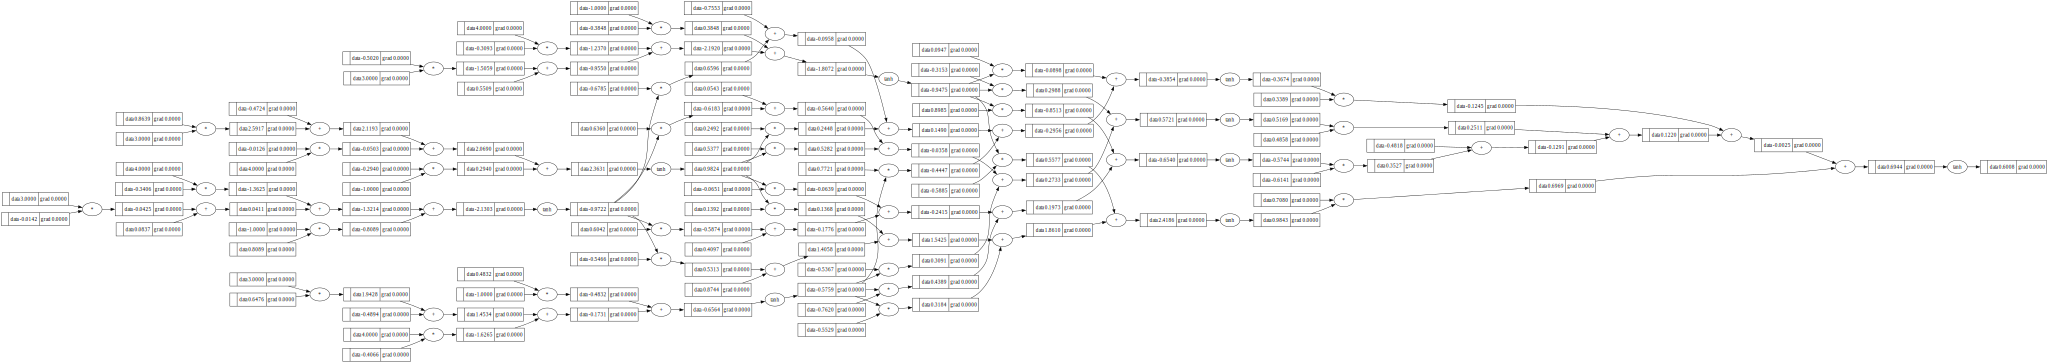

In [218]:
draw_dot(n(x))   #woaah

Data set creation and writing loss function

In [219]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[value(data=0.4722373760969182),
 value(data=0.3683520180898022),
 value(data=-0.37197486368673105),
 value(data=-0.1842542737185441)]

Aboc output is not the desired output. Calculating single number.loss function, to measure how well neuralnet is performing. In this case loss is high. ygt - y ground truth, yout is desired

In [220]:
#mean squared error loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

value(data=3.9477943892614373)

In [221]:
loss.backward()

In [222]:
n.layers[0].neurons[0].w[0].grad

-2.200763398330291

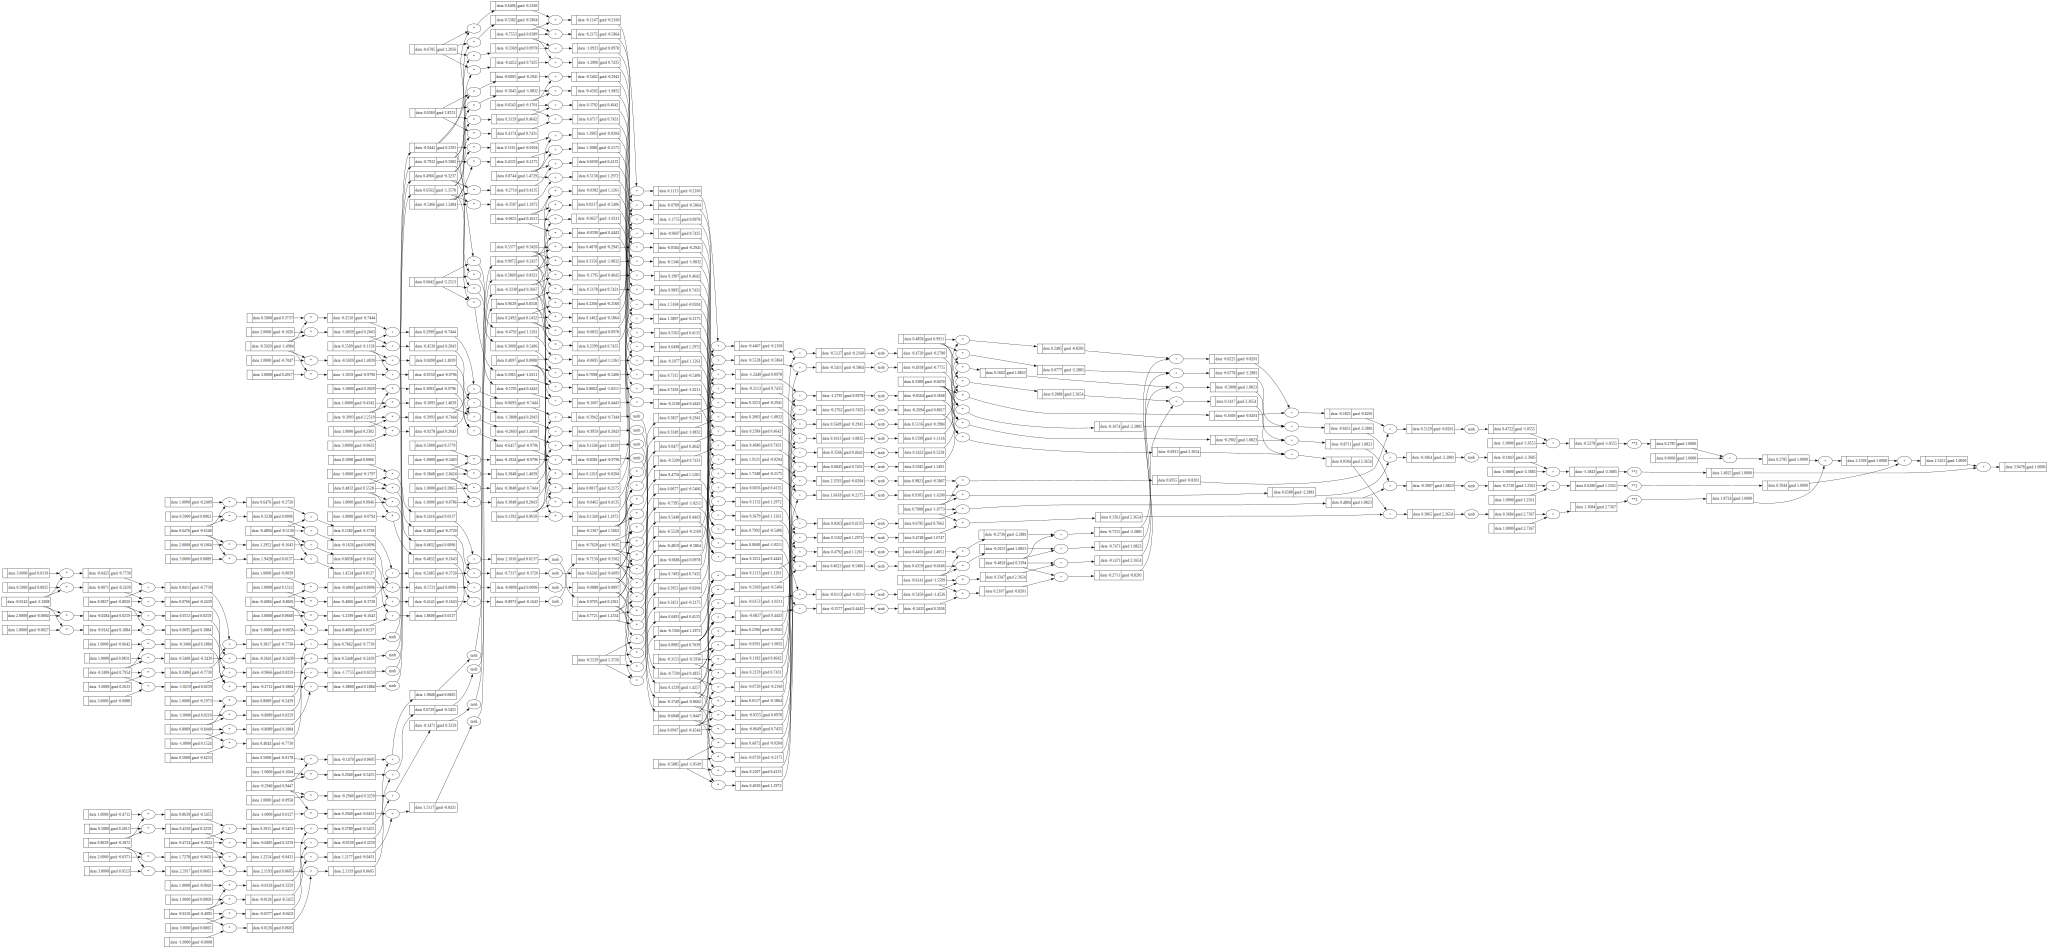

In [223]:
draw_dot(loss)

In [224]:
n.layers[0].neurons[0].w[0].grad

-2.200763398330291

In [225]:
n.layers[0].neurons[0].w[0].data

-0.014179745914671305

In [230]:
for p in n.parameters():
    p.data += -0.01*p.grad

In [231]:
n.layers[0].neurons[0].w[0].data

0.007827888068631612

In [232]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.378774346001274
1 0.6019637372660196
2 0.2007734510180711
3 0.11203590289654297
4 0.07985023440519923
5 0.0616644621255602
6 0.05003950624879672
7 0.04199793308104606
8 0.03611931250219349
9 0.0316427251999874
10 0.028124918460947772
11 0.025290708910684946
12 0.0229604735420859
13 0.02101211728330942
14 0.019359825546702982
15 0.017941565075245088
16 0.016711407379231262
17 0.015634638625509692
18 0.014684545234979016
19 0.013840242573366236


Getting closer

In [233]:
ypred

[value(data=0.9570046877378556),
 value(data=-0.9593992837580437),
 value(data=-0.9419367145572763),
 value(data=0.9165022011003651)]